In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from itertools import combinations


In [3]:
# --- Load the Dataset ---
# We use the cleaned CSV file provided.
file_path = '/Users/clarencemarvin/Downloads/centanet_cleaned_proximity.csv'

data = pd.read_csv(file_path)
print(f"Dataset loaded successfully: {file_path}")
print(f"Dataset shape: {data.shape}")


Dataset loaded successfully: /Users/clarencemarvin/Downloads/centanet_cleaned_proximity.csv
Dataset shape: (6156, 22)


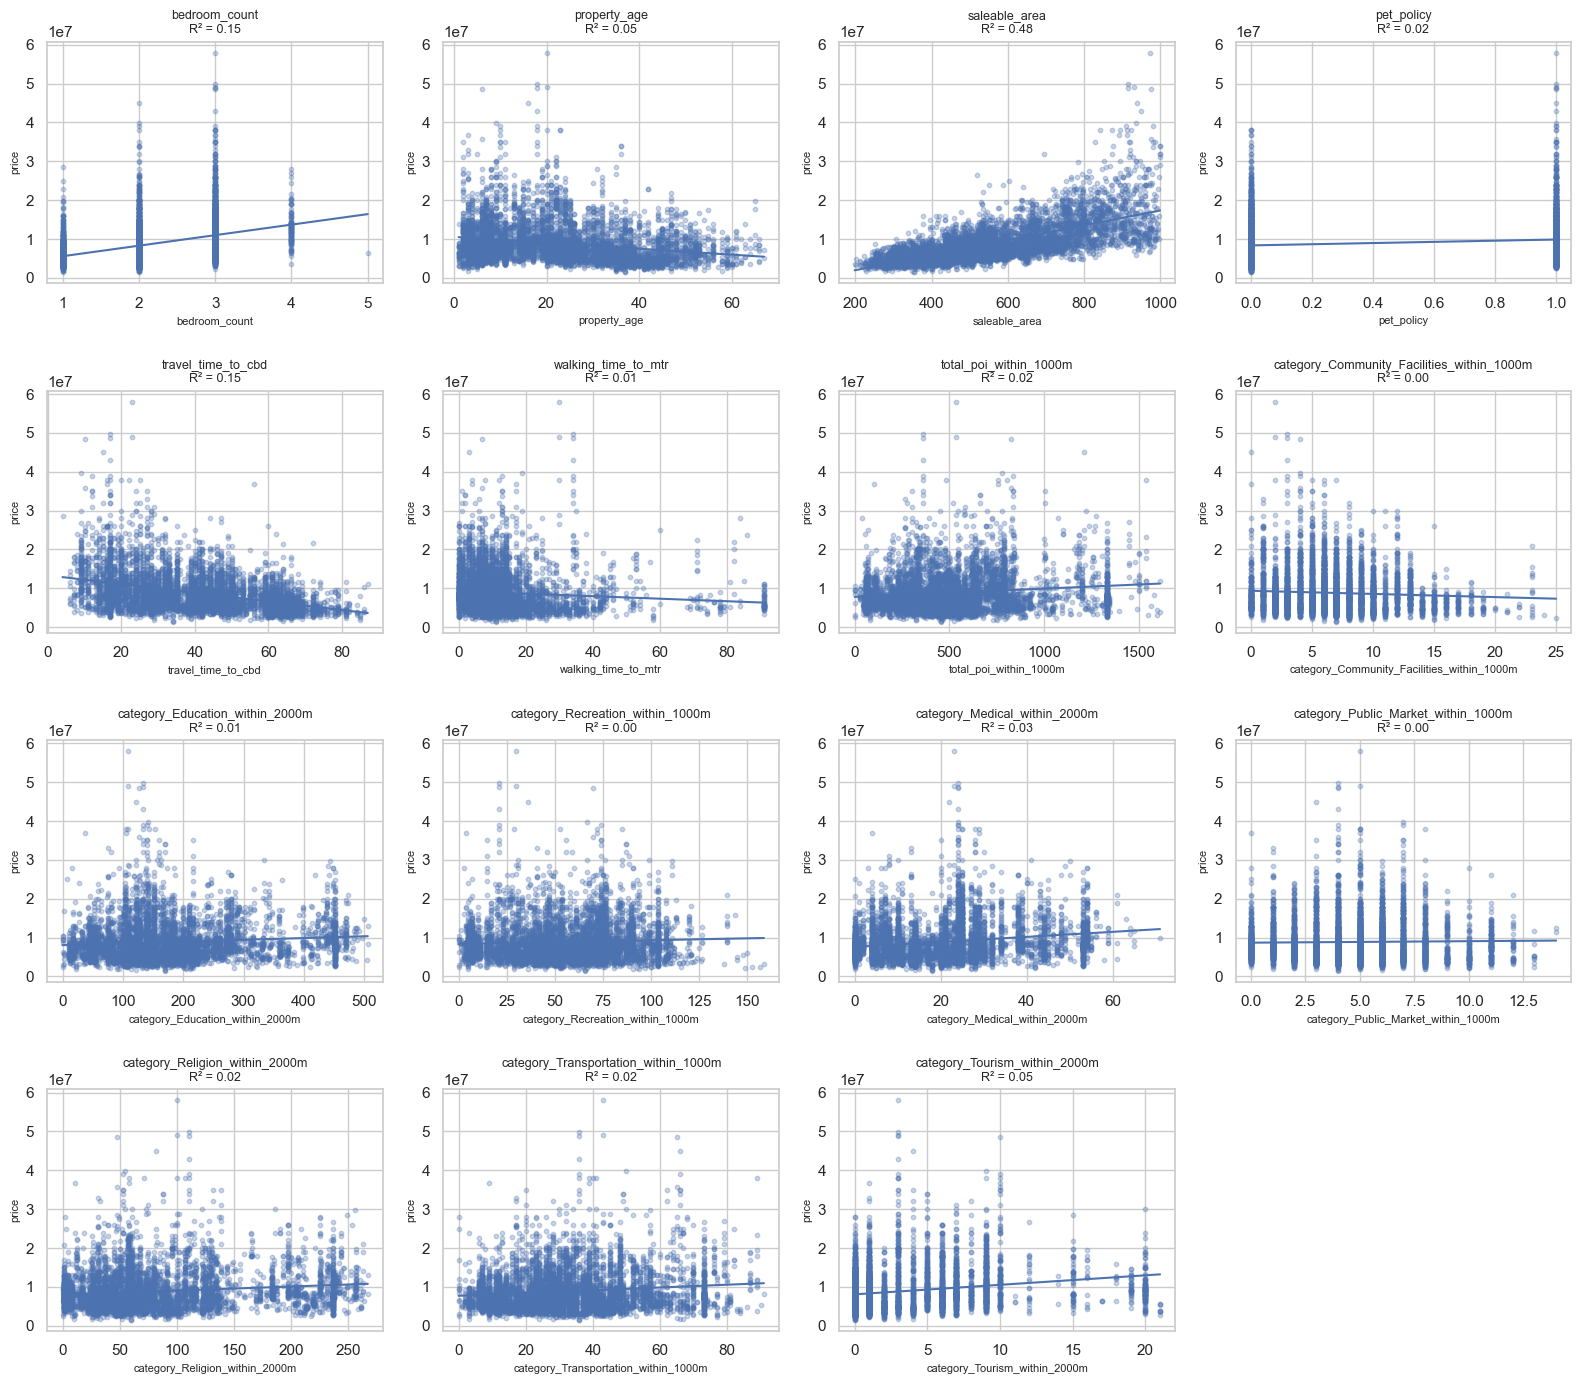

R² between each single variable and price:
                                       feature        r2
2                                saleable_area  0.479422
0                                bedroom_count  0.152433
4                           travel_time_to_cbd  0.150455
1                                 property_age  0.050575
14               category_Tourism_within_2000m  0.045711
10               category_Medical_within_2000m  0.034290
3                                   pet_policy  0.020086
12              category_Religion_within_2000m  0.018943
13        category_Transportation_within_1000m  0.017329
6                       total_poi_within_1000m  0.017324
8              category_Education_within_2000m  0.009864
5                          walking_time_to_mtr  0.007080
7   category_Community_Facilities_within_1000m  0.003857
9             category_Recreation_within_1000m  0.003339
11         category_Public_Market_within_1000m  0.000405


In [6]:
df = data.copy()
df = data.drop(columns=[
    "latitude",
    "longitude",
    "distance_to_nearest_mtr_km",
    "distance_to_nearest_match_km"
])

# Drop non-numeric / ID-like columns
df = df.drop(columns=["property_name", "district"])

# Convert bool to numeric
df["pet_policy"] = df["pet_policy"].astype(int)

# Target variable
y = df["price"]

# Features = everything except price
features = [col for col in df.columns if col != "price"]

# ------------------------------------------------------------
# 2. Fit single-variable regressions and plot in a grid
# ------------------------------------------------------------

results = []

n_features = len(features)
n_cols = 4                      # 4 columns in the grid
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = axes.flatten()           # make it easy to index

for idx, feature in enumerate(features):
    ax = axes[idx]

    X = df[[feature]].values    # 2D for sklearn
    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)
    results.append((feature, r2))

    # Scatter
    ax.scatter(df[feature], y, alpha=0.3, s=10)

    # Regression line
    x_line = np.linspace(df[feature].min(), df[feature].max(), 200)
    y_line = model.predict(x_line.reshape(-1, 1))
    ax.plot(x_line, y_line)

    ax.set_title(f"{feature}\nR² = {r2:.2f}", fontsize=9)
    ax.set_xlabel(feature, fontsize=8)
    ax.set_ylabel("price", fontsize=8)

# Hide any unused subplots (if features not multiple of n_cols)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. R² summary table
# ------------------------------------------------------------

r2_df = pd.DataFrame(results, columns=["feature", "r2"]).sort_values("r2", ascending=False)
print("R² between each single variable and price:")
print(r2_df)

Top 20 two-variable R²:
         feature1                                    feature2        r2
28  saleable_area                          travel_time_to_cbd  0.597135
14   property_age                               saleable_area  0.536534
1   bedroom_count                               saleable_area  0.524238
34  saleable_area               category_Medical_within_2000m  0.517470
38  saleable_area               category_Tourism_within_2000m  0.510976
37  saleable_area        category_Transportation_within_1000m  0.508205
30  saleable_area                      total_poi_within_1000m  0.504843
36  saleable_area              category_Religion_within_2000m  0.504322
29  saleable_area                         walking_time_to_mtr  0.496097
33  saleable_area            category_Recreation_within_1000m  0.494030
32  saleable_area             category_Education_within_2000m  0.492914
35  saleable_area         category_Public_Market_within_1000m  0.492228
27  saleable_area                       

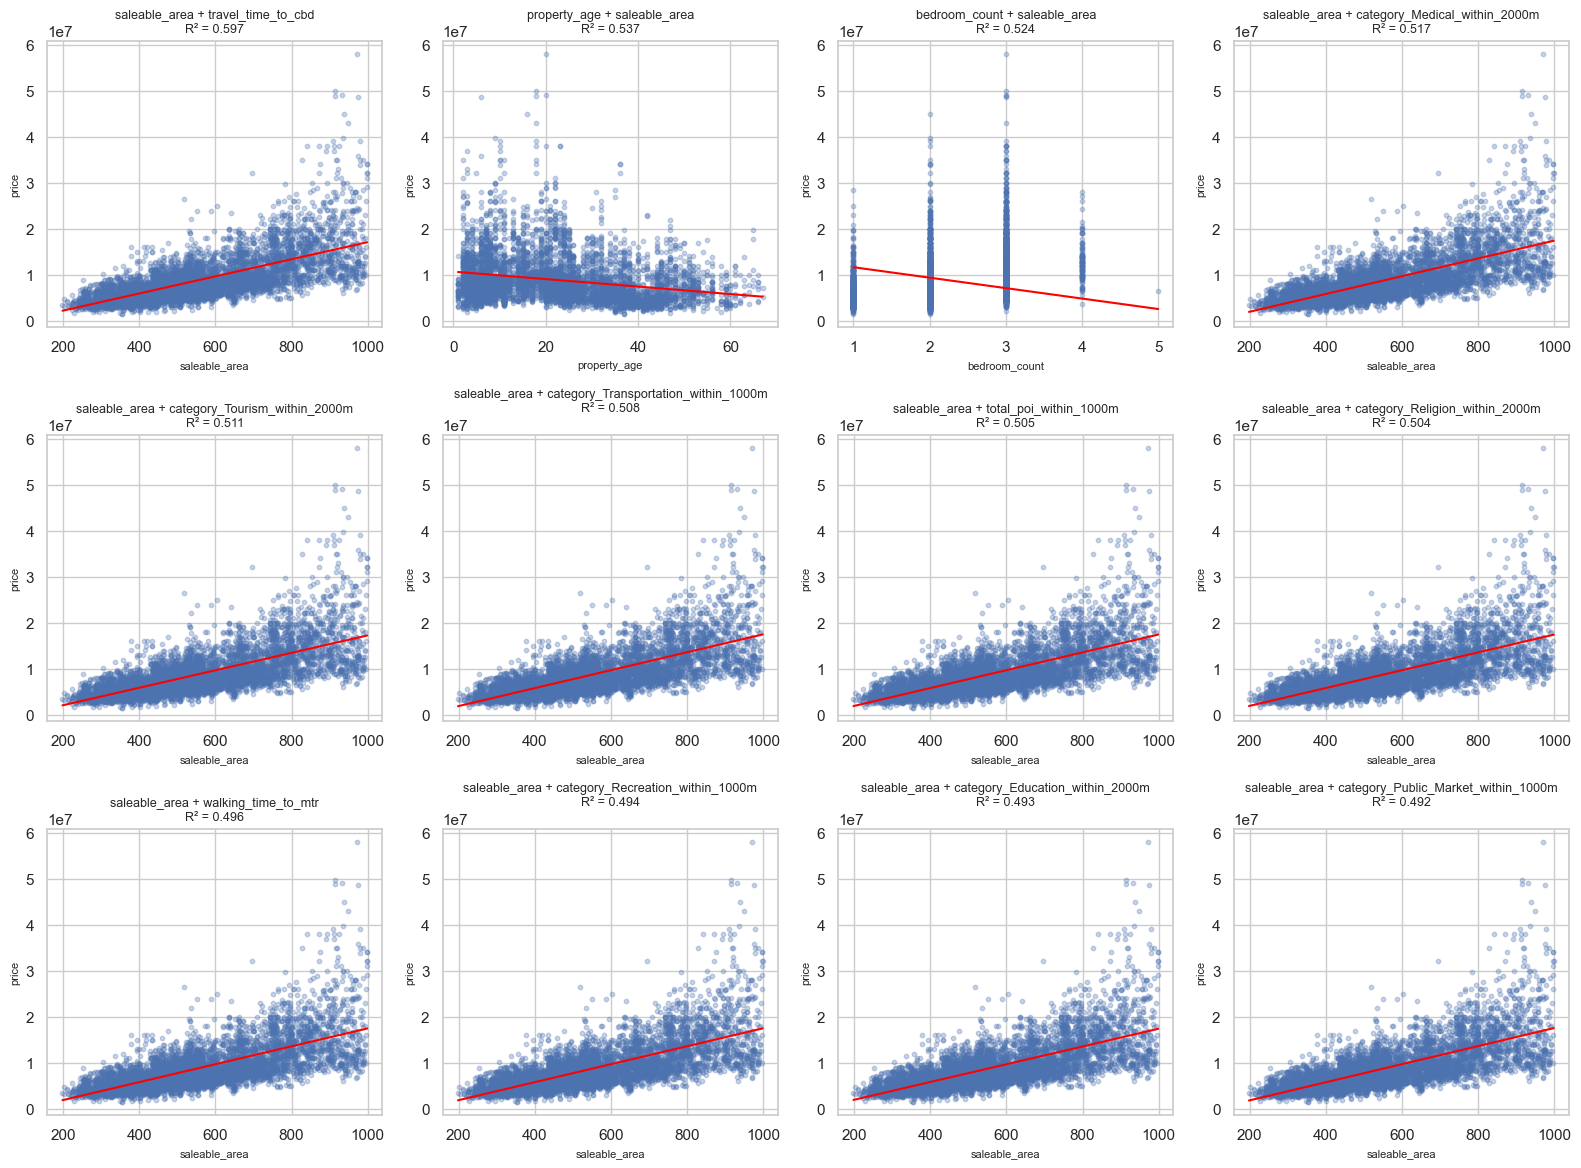

In [10]:
df2 = df.copy()
if "pet_policy" in df2.columns:
    df2["pet_policy"] = df2["pet_policy"].astype(int)

y = df2["price"].values
features = [c for c in df2.columns if c != "price"]

# ---------- 2. R² for all 2-variable combos ----------
pair_results = []

for f1, f2 in combinations(features, 2):
    X = df2[[f1, f2]]          # DataFrame with column names
    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)
    pair_results.append((f1, f2, r2))

pair_df = pd.DataFrame(pair_results, columns=["feature1", "feature2", "r2"])
pair_df = pair_df.sort_values("r2", ascending=False)

print("Top 20 two-variable R²:")
print(pair_df.head(20))

# Take top 12 for plotting
top12 = pair_df.head(12).reset_index(drop=True)

# ---------- 3. Plot top 12 pairs ----------
n_cols = 4
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, row in top12.iterrows():
    f1, f2, r2 = row["feature1"], row["feature2"], row["r2"]
    ax = axes[idx]

    # Fit model on both features
    X = df2[[f1, f2]]
    model = LinearRegression()
    model.fit(X, y)

    # Scatter: x = f1, y = price
    ax.scatter(df2[f1], y, alpha=0.3, s=10)

    # Regression line: vary f1, hold f2 at its mean
    x_line = np.linspace(df2[f1].min(), df2[f1].max(), 200)
    X_line = pd.DataFrame({
        f1: x_line,
        f2: df2[f2].mean()  # constant second feature
    })
    y_line = model.predict(X_line)
    ax.plot(x_line, y_line, color="red")

    ax.set_title(f"{f1} + {f2}\nR² = {r2:.3f}", fontsize=9)
    ax.set_xlabel(f1, fontsize=8)
    ax.set_ylabel("price", fontsize=8)

# Hide any unused axes (in case < 12 plots)
for j in range(len(top12), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Top 20 three-variable R²:
          feature1            feature2  \
92    property_age       saleable_area   
14   bedroom_count       saleable_area   
169  saleable_area          pet_policy   
184  saleable_area  travel_time_to_cbd   
181  saleable_area  travel_time_to_cbd   
182  saleable_area  travel_time_to_cbd   
183  saleable_area  travel_time_to_cbd   
189  saleable_area  travel_time_to_cbd   
185  saleable_area  travel_time_to_cbd   
188  saleable_area  travel_time_to_cbd   
186  saleable_area  travel_time_to_cbd   
180  saleable_area  travel_time_to_cbd   
187  saleable_area  travel_time_to_cbd   
102   property_age       saleable_area   
98    property_age       saleable_area   
101   property_age       saleable_area   
94    property_age       saleable_area   
97    property_age       saleable_area   
0    bedroom_count        property_age   
100   property_age       saleable_area   

                                       feature3        r2  
92                           tr

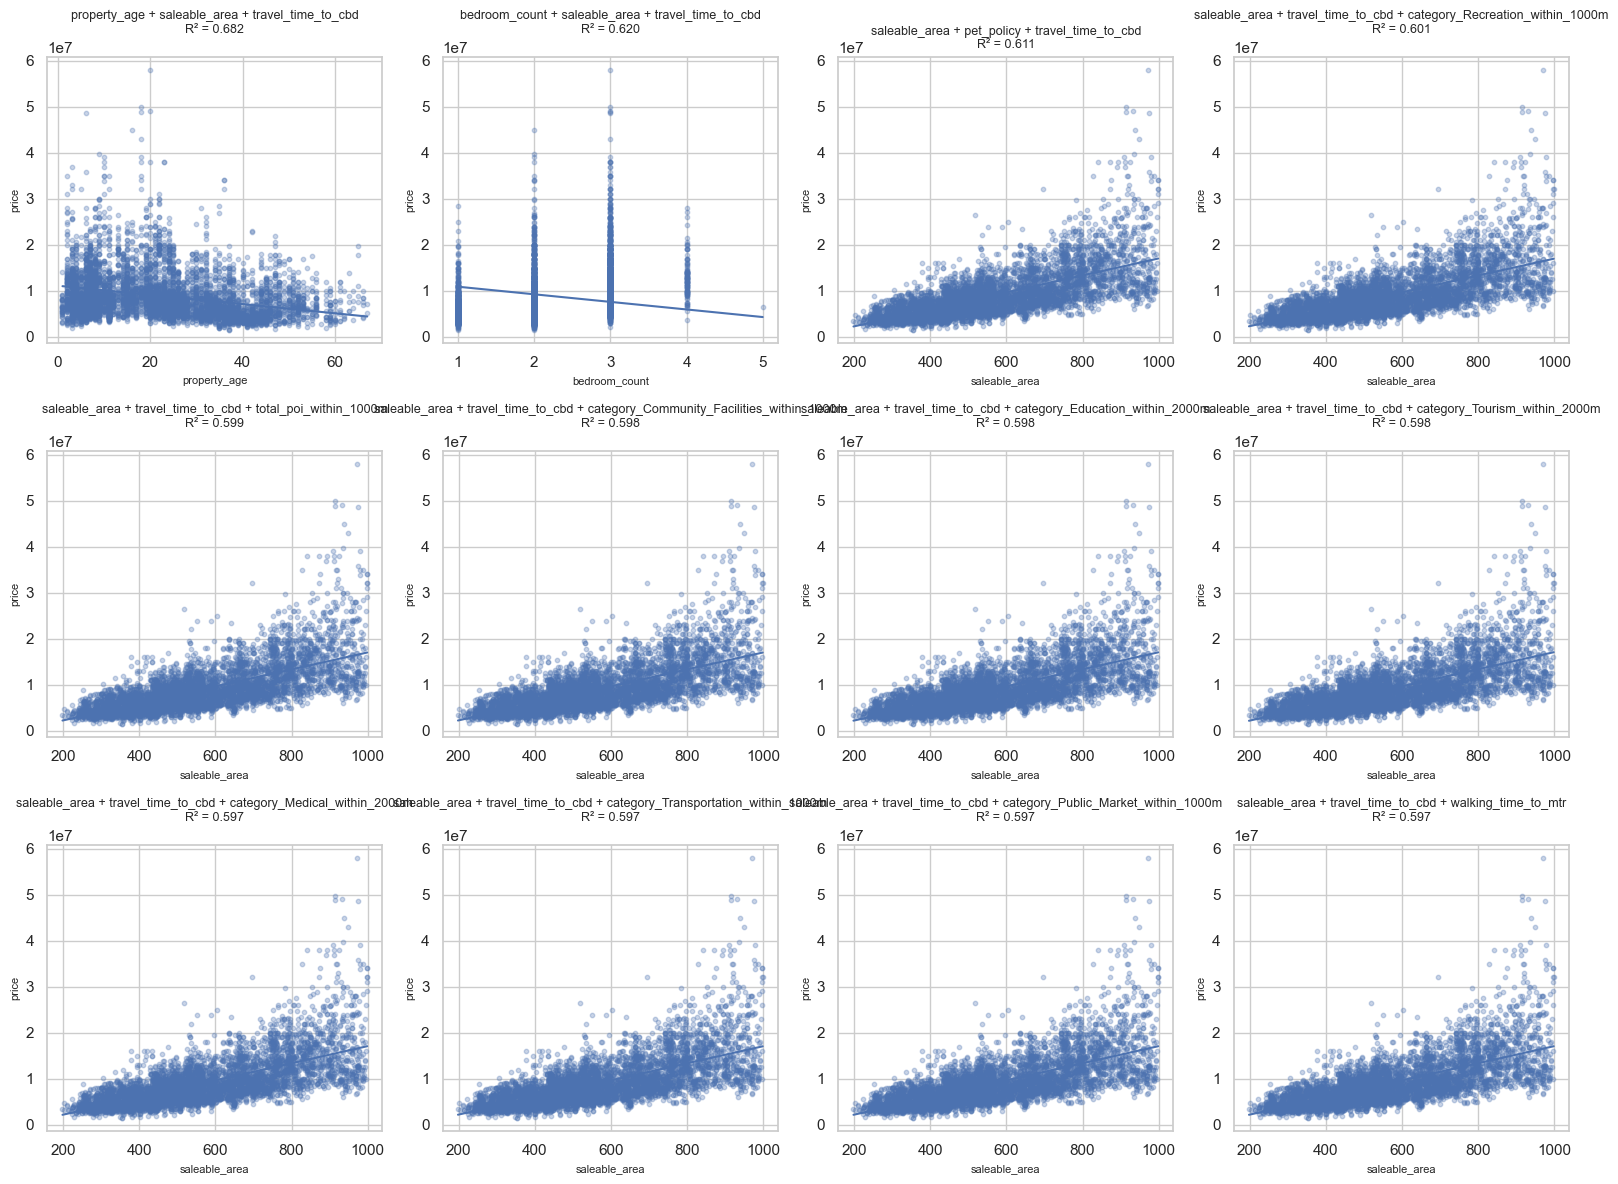

In [11]:
df3 = df.copy()
if "pet_policy" in df3.columns:
    df3["pet_policy"] = df3["pet_policy"].astype(int)

y = df3["price"].values
features = [c for c in df3.columns if c != "price"]

# ---------- 2. R² for all 3-variable combos ----------
triple_results = []

for f1, f2, f3 in combinations(features, 3):
    X = df3[[f1, f2, f3]]          # DataFrame with names
    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)
    triple_results.append((f1, f2, f3, r2))

triple_df = pd.DataFrame(triple_results,
                         columns=["feature1", "feature2", "feature3", "r2"])
triple_df = triple_df.sort_values("r2", ascending=False)

print("Top 20 three-variable R²:")
print(triple_df.head(20))

# Take top 12 for plotting
top12_3 = triple_df.head(12).reset_index(drop=True)

# ---------- 3. Plot top 12 triples ----------
n_cols = 4
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, row in top12_3.iterrows():
    f1, f2, f3, r2 = row["feature1"], row["feature2"], row["feature3"], row["r2"]
    ax = axes[idx]

    # Fit model on three features
    X = df3[[f1, f2, f3]]
    model = LinearRegression()
    model.fit(X, y)

    # Scatter: x = f1, y = price
    ax.scatter(df3[f1], y, alpha=0.3, s=10)

    # Regression line: vary f1, hold f2 & f3 at their means
    x_line = np.linspace(df3[f1].min(), df3[f1].max(), 200)
    X_line = pd.DataFrame({
        f1: x_line,
        f2: df3[f2].mean(),
        f3: df3[f3].mean()
    })
    y_line = model.predict(X_line)
    ax.plot(x_line, y_line)

    ax.set_title(f"{f1} + {f2} + {f3}\nR² = {r2:.3f}", fontsize=9)
    ax.set_xlabel(f1, fontsize=8)
    ax.set_ylabel("price", fontsize=8)

# Hide any unused axes (just in case)
for j in range(len(top12_3), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
